# 3.3. Find Balance of Friction with Static Analysis



In [1]:
%config InlineBackend.figure_format = "svg"
import numpy as np
from matplotlib import pyplot as plt
import sys
import pathlib
import os
sys.path.append(str(pathlib.Path(os.path.abspath('')).resolve().parent.parent))

from _9_Mechanics.Spiral import Spiral
from _9_Mechanics.Tribology import Tribology

TB = Tribology()


## 3.2.1. Optimal Mesh Number

### 3.2.1.1. Optimal Ratio of $r$ and $\theta$




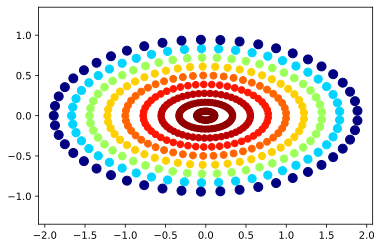

In [2]:
n = 49
r = (np.arange(int(n/5)) + 0.5) / int(n/5)
t = (np.arange(n) + 0.5) / n * 2 * np.pi

r_, t_ = np.meshgrid(r, t)
x_ = r_ * np.cos(t_) * 2.0 # = a 
y_ = r_ * np.sin(t_) * 1.0 # = b
F_ = np.sqrt(1 - np.square(r_))

plt.scatter(x_, y_, c=F_, cmap=plt.cm.jet, s=100*(1-F_*0.6))
plt.axis('equal')
plt.show()


In [3]:
dt = t[1] - t[0]
r_node = np.linspace(0., 1., int(n/5+1))
Antiderivative = lambda x: -(1-x*x)**1.5 / 2 / np.pi
ratio_dt = (Antiderivative(r_node[1:]) - Antiderivative(r_node[:-1])) * dt

r_, t_ = np.meshgrid(r, t)
ratio, t_ = np.meshgrid(ratio_dt, t)
ratio.sum()

1.0

In [4]:
R = 6.35 / 2
Rg = R * 1.08
ts = 45
tn = 45
dRs0 = R * 0.08 * np.cos(np.deg2rad(ts))
dRs1 = R * 0.08 * np.sin(np.deg2rad(ts))
dRn0 = R * 0.08 * np.cos(np.deg2rad(tn))
dRn1 = R * 0.08 * np.sin(np.deg2rad(tn))
PCR = 20.875
l = 10.0

SP1 = Spiral(alp=np.deg2rad(1e-1), l=l, r=PCR, eta=np.array([[-dRs0, -dRs1],[-dRs0, dRs1]]), R=np.array([Rg, Rg]))
SP2 = Spiral(alp=np.deg2rad(-1e-1), l=l, r=PCR, eta=np.array([[dRn0, -dRn1],[dRn0, dRn1]]), R=np.array([Rg, Rg]))
SP12 = [SP1, SP2]

rho = 7.9e-3 # [g/mm^3]
Ball_m = 4/3 * np.pi * R**3 * rho # [g]
Ball_I = 2/5 * Ball_m * R**2 # [g * mm^2]
Ball_r_inv = 1.0 / R
zeta = 0.2
E_Reduced = 231e3 # [N/mm^2]
rpm = 1000
w12 = np.array([[rpm * np.pi / 30, 0.0, 0.0], [0.0, 0.0, 0.0]])
v12 = w12 * l / 2 / np.pi
mu = 0.10

r_mesh = r_.reshape(-1)
t_mesh = t_.reshape(-1)
ratio_mesh = ratio.reshape(-1)
x_mesh = r_mesh * np.cos(t_mesh)
y_mesh = r_mesh * np.sin(t_mesh)


In [5]:
def Make_Matrix(a, b):
    return a.reshape(-1, 1) @ b.reshape(1, -1)

def vFmTI_ball(xvw_ball, t, mode):
    
    x_ball = xvw_ball[0:3]
    v_ball = xvw_ball[3:6]
    w_ball = xvw_ball[6:9]
    
    Zeros = np.zeros(3)
    vr = np.linalg.norm(v_ball)
    x_square = np.square(x_mesh)
    y_square = np.square(y_mesh)
    
    dx      = np.zeros([2, 2])
    k_      = dx.copy()
    a_      = dx.copy()
    b_      = dx.copy()
    v_      = dx.copy()
    F_norm  = dx.copy()

    cos_sin   = np.zeros([2, 2, 2])
    SP_r_inv  = cos_sin.copy()
    R_Reduced = cos_sin.copy()
    
    exyz    = np.zeros([2, 2, 3])
    F_      = exyz.copy()
    a_dir   = exyz.copy()
    peak    = exyz.copy()
    
    eta   = np.zeros([2, 3])
    b_dir = eta.copy()
    v_eta = eta.copy()
    
    xyz2eta = np.zeros([2, 3, 3])
    
    n_mesh = len(x_mesh)
    F_mesh = np.zeros([2, 2, n_mesh])
    
    p_mesh = np.zeros([2, 2, n_mesh, 3])
    SP_v   = p_mesh.copy()
    BL_v   = p_mesh.copy()
    dv     = p_mesh.copy()
    muT    = p_mesh.copy()

    v_dir = np.zeros([2, 2, 3, n_mesh])
    muF   = v_dir.copy()
    
    for iSP, SP in enumerate(SP12):
        
        eta[iSP,:] = SP.to_eta2(x_ball)
        xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
        b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])
        v_eta[iSP,:] = xyz2eta[iSP,:,:] @ v_ball

        for i in range(2):
            cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
            if dx[iSP,i] > 0:
                SP_r_inv[iSP,i,:] = SP.get_rho(cos_sin[iSP,i,0], i)
                R_Reduced[iSP,i,:] = 1.0 / (Ball_r_inv + SP_r_inv[iSP,i,:])
                k_[iSP,i], a_[iSP,i], b_[iSP,i] = TB.BrewHamrock(R_Reduced[iSP,i,0], R_Reduced[iSP,i,1], dx[iSP,i], E_Reduced)
                v_[iSP,i] = v_ball.dot(exyz[iSP,i,:])
                F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, v_[iSP,i], dx[iSP,i])
                F_[iSP,i,:] = - F_norm[iSP,i] * exyz[iSP,i,:]

                a_dir[iSP,i,:] = - np.cross(b_dir[iSP,:], exyz[iSP,i,:])
                
                peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]
                
                p_mesh[iSP,i,:,:] = peak[iSP,i,:] + Make_Matrix(a_[iSP,i] * x_mesh, a_dir[iSP,i,:]) + Make_Matrix(b_[iSP,i] * y_mesh, b_dir[iSP,:]) + Make_Matrix(0.5 * np.square(a_[iSP,i]) * x_square / R + 0.5 * np.square(b_[iSP,i]) * y_square / R, -exyz[iSP,i,:])
                F_mesh[iSP,i,:] = F_norm[iSP,i] * ratio_mesh
                
                SP_v[iSP,i,:,:]  = TB.surface_velocity(Zeros, p_mesh[iSP,i,:,:], v12[iSP], w12[iSP])
                BL_v[iSP,i,:,:]  = TB.surface_velocity(x_ball, p_mesh[iSP,i,:,:], v_ball, w_ball)
                dv[iSP,i,:,:]    = SP_v[iSP,i,:,:] - BL_v[iSP,i,:,:]
                v_dir[iSP,i,:,:] = dv[iSP,i,:,:].T * (1 / np.sqrt(np.square(dv[iSP,i,:,:]).sum(1)))
                muF[iSP,i,:,:] = F_mesh[iSP,i,:] * v_dir[iSP,i,:,:] * mu
                muT[iSP,i,:,:] = TB.calc_Torque(x_ball, p_mesh[iSP,i,:,:], muF[iSP,i,:,:].T)
                
    Fm_ball = (F_.sum(0).sum(0) + muF.sum(0).sum(0).sum(1)) / Ball_m * 1e6
    TI_ball = (muT.sum(0).sum(0).sum(0)) / Ball_I * 1e6
    
    if mode == 1:
        return a_, b_, a_dir, b_dir, dv

    if mode == 2:
        return a_, b_, a_dir, b_dir, muF, F_norm
    
    if mode == 3:
        return v_eta
    
    return np.concatenate([v_ball, Fm_ball, TI_ball])


In [6]:
xvw_ball = np.array([ 7.49214529e-01,  1.86156547e+01,  9.44934733e+00,  7.47973408e+01, -4.44066650e+02,  8.74837953e+02, -3.34519496e+02, -1.05000027e+02, -2.09607491e+01])


In [7]:
n = 49
r = (np.arange(int(n/5)) + 0.5) / int(n/5)
t = (np.arange(n) + 0.5) / n * 2 * np.pi

r_, t_ = np.meshgrid(r, t)

dt = t[1] - t[0]
r_node = np.linspace(0., 1., int(n/5+1))
Antiderivative = lambda x: -(1-x*x)**1.5 / 2 / np.pi
ratio_dt = (Antiderivative(r_node[1:]) - Antiderivative(r_node[:-1])) * dt

r_, t_ = np.meshgrid(r, t)
ratio, t_ = np.meshgrid(ratio_dt, t)
ratio.sum()


1.0

接触部分の曲面を放物線で近似する。以下の式で考える

$$
y \approx a x^2
$$

これを半径$r_1, r_2$,　弾性接近量$\Delta x$ で表す。曲率は$\chi=1/r$である。曲率は負の値も可能である。まず初めに以下の値のケースを考える。

| Variable   | Value |
|------------|-------|
| $r_1$      | 3     |
| $r_2$      | 5     |
| $\Delta x$ | 1     |
| $\chi_1$   | 1/3   |
| $\chi_2$   | 1/5   |


In [8]:
r1 = 3
r2 = 5
dx = 1
chi1 = 1 / r1
chi2 = 1 / r2


このとき $x, y, a$ は以下の式で表される。

$$
\begin{align}
x &= \frac{\sqrt{\Delta x (\chi_1 \Delta x - 2) (\chi_2 \Delta x - 2) (2 \chi_1 + 2 \chi_2 - \chi_1 \chi_2 \Delta x)}}{2 (\chi_1 + \chi_2 - \chi_1 \chi_2 \Delta x)} \\\\
y &= \frac{\chi_1 \Delta x - \chi_2 \Delta x}{2 (\chi_1 + \chi_2 - \chi_1 \chi_2 \Delta x)} \\\\
a &= \frac{2 (\chi_1 - \chi_2) (\chi_1 + \chi_2 - \chi_1 \chi_2 \Delta x)}{(\chi_1 \Delta x - 2) (\chi_2 \Delta x - 2) (2 \chi_1 + 2 \chi_2 - \chi_1 \chi_2 \Delta x)} \\\\
\end{align}
$$

今回値は以下となる。

| Variable   | Value |
|------------|-------|
| $x$      |1.8557687223952255|
| $y$      |0.1428571428571428|
| $a$      |0.041481481481481466|


In [9]:
def circle1(x, y):
    return np.sqrt(x**2 + (y - (r1 - dx/2))**2)

def circle2(x, y):
    return np.sqrt(x**2 + (y - (-r2 + dx/2))**2)

x = np.sqrt(dx * (chi1 * dx - 2) * (chi2 * dx - 2) * (2 * chi1 + 2 * chi2 - chi1 * chi2 * dx))/(2 * (chi1 + chi2 - chi1 * chi2 * dx))
y = (chi1 * dx - chi2 * dx)/(2 * (chi1 + chi2 - chi1 * chi2 * dx))
a = 2 * (chi1 - chi2) * (chi1 + chi2 - chi1 * chi2 * dx) / (chi1 * dx - 2) / (chi2 * dx - 2) / (2 * chi1 + 2 * chi2 - chi1 * chi2 * dx)

print("x: " + str(x))
print("y: " + str(y))
print("a: " + str(a))
print("ax2: " + str(a*x*x) + " (= y)")

print("r1: " + str(circle1(x, y)))
print("r2: " + str(circle2(x, y)))


x: 1.8557687223952255
y: 0.14285714285714282
a: 0.041481481481481466
ax2: 0.1428571428571428 (= y)
r1: 3.0
r2: 5.0


逆側の場合（曲率が負の場合）も考える。$x, y, a$を与える数式は変わらない。条件と結果は以下となる。

| Variable   | Value |
|------------|-------|
| $r_1$      | 3     |
| $r_2$      | -5    |
| $\Delta x$ | 1     |
| $\chi_1$   | 1/3   |
| $\chi_2$   | -1/5  |
| $x$      |2.7638539919628338|
| $y$      |1.3333333333333337|
| $a$      |0.1745454545454545|



In [13]:
r1 = 3
r2 = -5
dx = 1
chi1 = 1 / r1
chi2 = 1 / r2

def circle1(x, y):
    return np.sqrt(x**2 + (y - (r1 - dx/2))**2)

def circle2(x, y):
    return np.sqrt(x**2 + (y - (-r2 + dx/2))**2)

x = np.sqrt(dx * (chi1 * dx - 2) * (chi2 * dx - 2) * (2 * chi1 + 2 * chi2 - chi1 * chi2 * dx))/(2 * (chi1 + chi2 - chi1 * chi2 * dx))
y = (chi1 * dx - chi2 * dx)/(2 * (chi1 + chi2 - chi1 * chi2 * dx))
a = 2 * (chi1 - chi2) * (chi1 + chi2 - chi1 * chi2 * dx) / (chi1 * dx - 2) / (chi2 * dx - 2) / (2 * chi1 + 2 * chi2 - chi1 * chi2 * dx)

print("x: " + str(x))
print("y: " + str(y))
print("a: " + str(a))
print("ax2: " + str(a*x*x) + " (= y)")

print("r1: " + str(circle1(x, y)))
print("r2: " + str(circle2(x, y)))

chi2

x: 2.7638539919628338
y: 1.3333333333333337
a: 0.17454545454545453
ax2: 1.3333333333333337 (= y)
r1: 3.0000000000000004
r2: 5.0


-0.2

In [14]:
print(a)
print(TB.Parabola(chi1, chi2, dx))


0.17454545454545453
0.17454545454545453


In [12]:
x_ball = xvw_ball[0:3]
v_ball = xvw_ball[3:6]
w_ball = xvw_ball[6:9]

Zeros = np.zeros(3)
vr = np.linalg.norm(v_ball)
x_square = np.square(x_mesh)
y_square = np.square(y_mesh)

dx      = np.zeros([2, 2])
k_      = dx.copy()
a_      = dx.copy()
b_      = dx.copy()
v_      = dx.copy()
F_norm  = dx.copy()

cos_sin   = np.zeros([2, 2, 2])
SP_r_inv  = cos_sin.copy()
R_Reduced = cos_sin.copy()

exyz    = np.zeros([2, 2, 3])
F_      = exyz.copy()
a_dir   = exyz.copy()
peak    = exyz.copy()

eta   = np.zeros([2, 3])
b_dir = eta.copy()
v_eta = eta.copy()

xyz2eta = np.zeros([2, 3, 3])

n_mesh = len(x_mesh)
F_mesh = np.zeros([2, 2, n_mesh])

p_mesh = np.zeros([2, 2, n_mesh, 3])
SP_v   = p_mesh.copy()
BL_v   = p_mesh.copy()
dv     = p_mesh.copy()
muT    = p_mesh.copy()

v_dir = np.zeros([2, 2, 3, n_mesh])
muF   = v_dir.copy()

for iSP, SP in enumerate(SP12):

    eta[iSP,:] = SP.to_eta2(x_ball)
    xyz2eta[iSP,:,:] = SP.get_xyz2eta(eta[iSP,0])
    b_dir[iSP,:] = xyz2eta[iSP,:,:].T @ np.array([1.0, 0.0, 0.0])
    v_eta[iSP,:] = xyz2eta[iSP,:,:] @ v_ball

    for i in range(2):
        cos_sin[iSP,i], dx[iSP,i], exyz[iSP,i,:] = SP.get_contact(x_ball, R, i)
        if dx[iSP,i] > 0:
            SP_r_inv[iSP,i,:] = SP.get_rho(cos_sin[iSP,i,0], i)
            R_Reduced[iSP,i,:] = 1.0 / (Ball_r_inv + SP_r_inv[iSP,i,:])
            k_[iSP,i], a_[iSP,i], b_[iSP,i] = TB.BrewHamrock(R_Reduced[iSP,i,0], R_Reduced[iSP,i,1], dx[iSP,i], E_Reduced)
            v_[iSP,i] = v_ball.dot(exyz[iSP,i,:])
            F_norm[iSP,i] = TB.Tsuji(k_[iSP,i], zeta, Ball_m, v_[iSP,i], dx[iSP,i])
            F_[iSP,i,:] = - F_norm[iSP,i] * exyz[iSP,i,:]

            a_dir[iSP,i,:] = - np.cross(b_dir[iSP,:], exyz[iSP,i,:])

            peak[iSP,i,:] = x_ball + (R - dx[iSP,i] / 2) * exyz[iSP,i,:]

            p_mesh[iSP,i,:,:] = peak[iSP,i,:] + Make_Matrix(a_[iSP,i] * x_mesh, a_dir[iSP,i,:]) + Make_Matrix(b_[iSP,i] * y_mesh, b_dir[iSP,:]) + Make_Matrix(0.5 * np.square(a_[iSP,i]) * x_square / R + 0.5 * np.square(b_[iSP,i]) * y_square / R, -exyz[iSP,i,:])
            
            R_hoge = R * 1.08
            print('peak')
            print(np.linalg.norm(x_ball - peak[iSP,i,:]))
            p_a = peak[iSP,i,:] + a_[iSP,i] * a_dir[iSP,i,:] - 0.5 * np.square(a_[iSP,i]) / R_hoge * exyz[iSP,i,:]
            dist_a = p_a - x_ball
            print('a')
            print(np.linalg.norm(dist_a))
            p_b = peak[iSP,i,:] + b_[iSP,i] * b_dir[iSP,:] - 0.5 * np.square(b_[iSP,i]) / R_hoge * exyz[iSP,i,:]
            dist_b = p_b - x_ball 
            print('b')
            print(np.linalg.norm(dist_b))
            
            
            print(R)
            print(1 / SP_r_inv[iSP,i,:])
            
            F_mesh[iSP,i,:] = F_norm[iSP,i] * ratio_mesh

            SP_v[iSP,i,:,:]  = TB.surface_velocity(Zeros, p_mesh[iSP,i,:,:], v12[iSP], w12[iSP])
            BL_v[iSP,i,:,:]  = TB.surface_velocity(x_ball, p_mesh[iSP,i,:,:], v_ball, w_ball)
            dv[iSP,i,:,:]    = SP_v[iSP,i,:,:] - BL_v[iSP,i,:,:]
            v_dir[iSP,i,:,:] = dv[iSP,i,:,:].T * (1 / np.sqrt(np.square(dv[iSP,i,:,:]).sum(1)))
            muF[iSP,i,:,:] = F_mesh[iSP,i,:] * v_dir[iSP,i,:,:] * mu
            muT[iSP,i,:,:] = TB.calc_Torque(x_ball, p_mesh[iSP,i,:,:], muF[iSP,i,:,:].T)

Fm_ball = (F_.sum(0).sum(0) + muF.sum(0).sum(0).sum(1)) / Ball_m * 1e6
TI_ball = (muT.sum(0).sum(0).sum(0)) / Ball_I * 1e6


peak
3.173991162931934
a
3.175435995138291
b
3.1740326288742122
3.175
[27.02890381 -3.429     ]
peak
3.1748265965245155
a
3.1750620335333153
b
3.1748357014111828
3.175
[-32.6469086  -3.429    ]
peak
3.1740325284604145
a
3.175384773329198
b
3.174083514805873
3.175
[-32.82934461  -3.429     ]
